# Histogram

In [1]:
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import numpy as np

[584, 591, 590, 578, 594, 598, 597, 600]


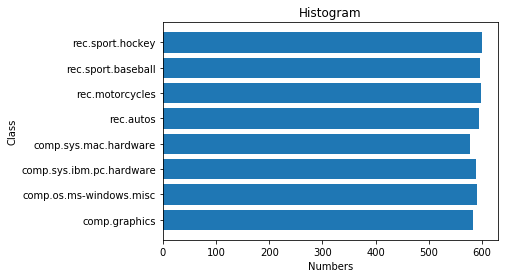

In [2]:
categories =['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
dataLen = []
train_datas =[]
for cat in categories:
    raw_train = fetch_20newsgroups(subset='train',categories = [cat],shuffle=True, random_state =42)
    train_datas.append(raw_train.data)
    dataLen.append(len(raw_train.data))
print(dataLen)
# the histogram of the data
plt.title('Histogram')
plt.xlabel('Numbers')
plt.ylabel('Class')
plt.barh(categories,dataLen)
plt.show()

# Binary Classification

## 1. Raw data

In [3]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle=True,random_state=None)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle=True,random_state=None)

## 2. Preprocessing

### (1) stop words and lemmatizer

In [5]:
## stop words
import nltk
from sklearn.feature_extraction import text
stop_words_skt = text.ENGLISH_STOP_WORDS
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_en = stopwords.words('english')
from string import punctuation
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

In [7]:
## Lemmatizer
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent_demo(text):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(nltk.word_tokenize(text))]
def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

In [8]:
# overwrite analyzer with callable function:
from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))
def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not is_number(word))

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [9]:
# vectorizer
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')
x_train_counts = count_vect.fit_transform(train_dataset.data)
x_test_counts = count_vect.transform(test_dataset.data)

## TFIDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)


### (2) dimension reduction

In [11]:
## NMF
from sklearn.decomposition import NMF
NMF_reduction = NMF(n_components=50, init='random', random_state=0)

# train data
NMF_reduced_train = NMF_reduction.fit_transform(x_train_tfidf)
H = NMF_reduction.components_
print(np.sum(np.array(x_train_tfidf - NMF_reduced_train.dot(H))**2)) # frob norm of NMF

# test data
NMF_reduced_test = NMF_reduction.transform(x_test_tfidf)
H = NMF_reduction.components_
print(np.sum(np.array(x_test_tfidf - NMF_reduced_test.dot(H))**2)) # frob norm of NMF

4142.91864616
2847.85792785


In [19]:
## LSI
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=50, random_state=0)

# # train data
SVD_reduced_train = SVD.fit_transform(x_train_tfidf)
VT = SVD.components_
print(np.sum(np.array(x_train_tfidf - SVD_reduced_train.dot(VT))**2)) # frob norm of SVD

# test data
SVD_reduced_test = SVD.transform(x_test_tfidf)
VT = SVD.components_
print(np.sum(np.array(x_test_tfidf - SVD_reduced_test.dot(VT))**2)) # frob norm of SVD

4107.80254379
2835.63498755


## 3. Pipelines

### (1) pipelines

In [21]:
## helper functions
from sklearn.base import BaseEstimator, TransformerMixin
class SparseToDenseArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, *_):
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

    def fit(self, *_):
        return self

In [64]:
## Pipelines 
# name conventions: min_df_{param1}_{reduce_dim param2}_{classifier param3}
# param1: number n: min_df_2 => min_df = 2
# param2: NMF and SVD
# param3: NB for Naive Bayes, LR for Logit Regression, SVM for SVM

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

# SVM
pipe_min_df_3_NMF_SVM_soft = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(n_components=50, init='random', random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', probability=True, C=0.0001)),
])

pipe_min_df_3_LSI_SVM_soft = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', probability=True, C=0.0001)),
])

pipe_min_df_3_NMF_SVM_hard = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(n_components=50, init='random', random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', probability=True, C=1000)),
])

pipe_min_df_3_LSI_SVM_hard = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', probability=True, C=1000)),
])

# Logit Regression
pipe_min_df_3_NMF_LR_unregularized = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(n_components=50, init='random', random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', LogisticRegression(penalty='l2', C=1000000000)), # use l2 and large C for unregularized LR
])

pipe_min_df_3_NMF_LR_regularized = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(n_components=50, init='random', random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', LogisticRegression()), 
])

# Naive Bayes
pipe_min_df_3_NMF_NB = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(n_components=50, init='random', random_state=0)),
    ('clf', GaussianNB()),
])

pipe_min_df_3_LSI_NB = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', GaussianNB()),
])


### (2) helper functions for plots and metrics

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
%matplotlib inline

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)
        
def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])
    plot_roc(fpr, tpr)
    
    predicted_labels = pipe.predict(test_data)
    print('confusion_matrix =', '\n', confusion_matrix(test_label, predicted_labels))
    print('accuracy score =', accuracy_score(test_label, predicted_labels))
    print('recall score =', recall_score(test_label, predicted_labels))
    print('precision score =', precision_score(test_label, predicted_labels))
    print('F1 score =', f1_score(test_label, predicted_labels))
    [fpr, tpr]

### (3) results for pipelines

confusion_matrix = 
 [[   0 1560]
 [   0 1590]]
accuracy score = 0.504761904762
recall score = 1.0
precision score = 0.504761904762
F1 score = 0.670886075949


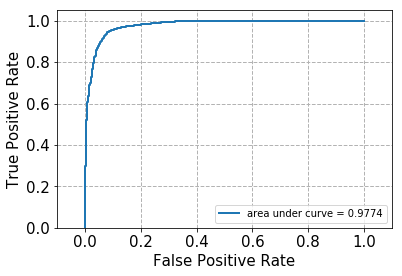

In [67]:
# soft SVM
fit_predict_and_plot_roc(pipe_min_df_3_NMF_SVM_soft, train_dataset.data, train_dataset.target > 3, test_dataset.data, test_dataset.target > 3)

confusion_matrix = 
 [[   0 1560]
 [   0 1590]]
accuracy score = 0.504761904762
recall score = 1.0
precision score = 0.504761904762
F1 score = 0.670886075949


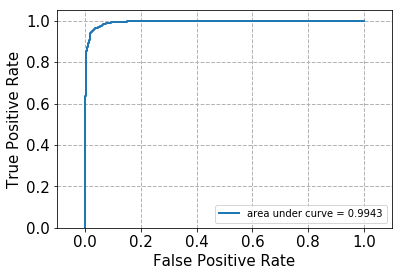

In [77]:
# soft SVM
fit_predict_and_plot_roc(pipe_min_df_3_LSI_SVM_soft, train_dataset.data, train_dataset.target > 3, test_dataset.data, test_dataset.target > 3)

confusion_matrix = 
 [[1539   51]
 [  61 1499]]
accuracy score = 0.964444444444
recall score = 0.960897435897
precision score = 0.967096774194
F1 score = 0.963987138264


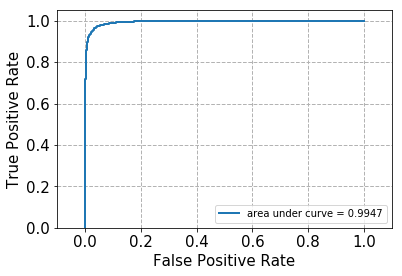

In [40]:
# hard SVM
fit_predict_and_plot_roc(pipe_min_df_3_NMF_SVM_hard, train_dataset.data, train_dataset.target <= 3, test_dataset.data, test_dataset.target <= 3)

confusion_matrix = 
 [[1556   34]
 [  51 1509]]
accuracy score = 0.973015873016
recall score = 0.967307692308
precision score = 0.97796500324
F1 score = 0.972607154367


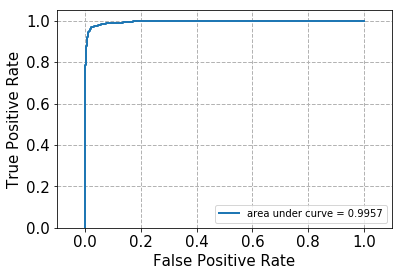

In [61]:
# hard SVM
fit_predict_and_plot_roc(pipe_min_df_3_LSI_SVM_hard, train_dataset.data, train_dataset.target <= 3, test_dataset.data, test_dataset.target <= 3)

In [75]:
# find the best C for SVM

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
# from sklearn import metrics
from sklearn.svm import SVC

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
C_OPTIONS = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
maxScore = 0
maxC = 0.001

# use SVD to reduce dimension
svm_scores = []
for c in C_OPTIONS:
    scores = cross_val_score(SVC(C=c), SVD_reduced_train, train_dataset.target <= 3, cv=cv, scoring='accuracy')
    avg = sum(scores) / float(len(scores))
    svm_scores.append(avg)
    if maxScore < avg:
        maxScore = avg
        maxC = c
        
print([maxScore, maxC])
print(svm_scores)

[0.97296726504751851, 1000]
[0.48933474128827881, 0.48933474128827881, 0.48933474128827881, 0.95269271383315723, 0.97043294614572351, 0.97254487856388594, 0.97296726504751851]


confusion_matrix = 
 [[1539   51]
 [  61 1499]]
accuracy score = 0.964444444444
recall score = 0.960897435897
precision score = 0.967096774194
F1 score = 0.963987138264


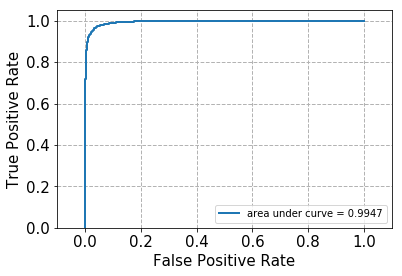

In [48]:
# pipeline for SVM with best C
pipe_min_df_3_LSI_SVM_bestC = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', probability=True, C=maxC)),
])

fit_predict_and_plot_roc(pipe_min_df_3_NMF_SVM_hard, train_dataset.data, train_dataset.target <= 3, test_dataset.data, test_dataset.target <= 3)

In [44]:
# find the best C for SVM

from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
from sklearn.model_selection import KFold

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', SVC()),
],
memory=memory
)

C_OPTIONS = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv = KFold(n_splits=5)

param_grid = [
    {
        'clf': [SVC()],
        'clf__C': C_OPTIONS
    },
]

grid = GridSearchCV(pipeline, cv=cv, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_dataset.data, train_dataset.target <= 3)
rmtree(cachedir)
print("The best parameters are %s with a score of %0.2f" %(grid.best_params_, grid.best_score_))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc at 0x121d8eae8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=3, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None), 
None, [ 'From: der10@cus.cam.ac.uk (David Rourke)\n'
  'Subject: xs1100 timing\n'
  'Organization: U of Cambridge, England\n'
  'Lines: 4\n'
  'Nntp-Posting-Host: bootes.cus.cam.ac.uk\n'
  '\n'
  'Could some kind soul tell me the advance timing/revs for a 1981 xs1100 '
  'special\n'
  '(bought in Canada).\n'
  '\n'
  'thanks.\n',
  'From: boyle@cactus.org (Craig Boyle)\n'
  "Subject: Re: New break pads & exhausts after 96K km

KeyboardInterrupt: 

confusion_matrix = 
 [[1537   53]
 [  66 1494]]
accuracy score = 0.962222222222
recall score = 0.957692307692
precision score = 0.965740142211
F1 score = 0.961699388478


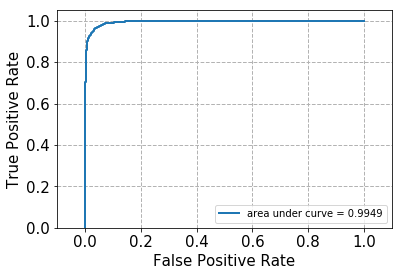

In [38]:
# Logit Regression Unregularized
fit_predict_and_plot_roc(pipe_min_df_3_NMF_LR_unregularized, train_dataset.data, train_dataset.target <= 3, test_dataset.data, test_dataset.target <= 3)

In [81]:
# regularized logit regression: find the best parameter for both l1 and l2 penalty

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
C_OPTIONS = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# use SVD to reduce dimension
maxCs = []
maxScores = []
l1_scores = []
l2_scores = []
for l in ['l1', 'l2']:    
    maxScore = 0
    curMaxC = 0.001
    for c in C_OPTIONS:
        scores = cross_val_score(LogisticRegression(penalty=l, C=c), SVD_reduced_train, train_dataset.target <= 3, cv=cv, scoring='accuracy')
        avg = sum(scores) / float(len(scores))
        if l == 'l1':
            l1_scores.append(avg)
        else:
            l2_scores.append(avg)
        if maxScore < avg:
            maxScore = avg
            curMaxC = c
    maxCs.append(curMaxC) 
    maxScores.append(maxScore)
print("Best C for l1 is", maxCs[0], "with accuracy =", maxScores[0])
print("Best C for l2 is", maxCs[1], "with accuracy =", maxScores[1])

Best C for l1 is 100 with accuracy = 0.973812038015
Best C for l2 is 100 with accuracy = 0.973600844773


In [83]:
# learnt coefficients
cur_clf = LogisticRegression(penalty='l1', C=100)
cur_clf.fit(SVD_reduced_train, train_dataset.target <= 3)
print(cur_clf.coef_)

[[  7.91883181e+00  -1.18959207e+02   2.33558183e+01  -8.62608809e+01
   -1.45932606e+01   1.19138802e+01   4.57533118e+00  -1.45057731e+00
   -2.35096314e+01  -1.42378871e+01  -3.50834206e+01   4.57657242e+00
    8.05801043e+00  -6.04859434e+00  -1.66747805e+01  -5.79928310e+00
    9.09506852e+00   4.92830069e-01  -1.40925117e+01   7.54366009e-02
   -8.24299912e-01   1.38582770e+01   1.01833559e+01  -3.86647756e+00
   -3.33190847e+00  -5.22552539e+00  -1.45059872e+01   8.26605800e+00
   -1.16661339e+00  -1.40951251e+01  -1.40893282e+01   7.99108296e+00
   -4.97970735e+00   4.97943813e+00  -2.57316655e+00   1.75912049e-01
    1.19262286e+01   6.66949299e+00   1.39309712e+00  -9.56115903e+00
    2.24751036e+00   5.14726258e+00  -9.43197948e+00   3.99400141e+00
   -6.91667131e+00   2.48279695e+00   2.21643743e+00  -6.11448335e+00
   -1.66539943e+00   1.42457841e+00]]


TypeError: object of type 'LogisticRegression' has no len()

confusion_matrix = 
 [[1553   37]
 [  62 1498]]
accuracy score = 0.968571428571
recall score = 0.960256410256
precision score = 0.975895765472
F1 score = 0.968012924071
confusion_matrix = 
 [[1554   36]
 [  61 1499]]
accuracy score = 0.969206349206
recall score = 0.960897435897
precision score = 0.97654723127
F1 score = 0.968659127625


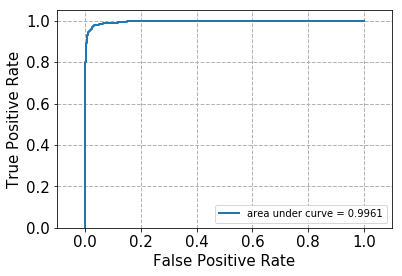

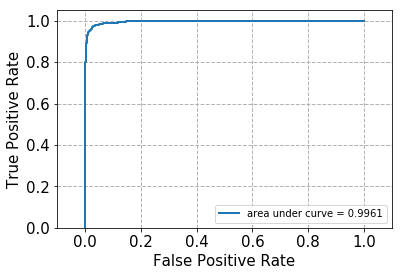

In [54]:
# Compare the unregularized, l1-regularized, l2-regularized with test data

pipe_min_df_3_SVD_LR_l1Regularized_bestC = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', LogisticRegression(penalty='l1', C=maxCs[0])),
])

pipe_min_df_3_SVD_LR_l2Regularized_bestC = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', LogisticRegression(penalty='l2', C=maxCs[1])), 
])

# l1
fit_predict_and_plot_roc(pipe_min_df_3_SVD_LR_l1Regularized_bestC, train_dataset.data, train_dataset.target <= 3, test_dataset.data, test_dataset.target <= 3)

# l2
fit_predict_and_plot_roc(pipe_min_df_3_SVD_LR_l2Regularized_bestC, train_dataset.data, train_dataset.target <= 3, test_dataset.data, test_dataset.target <= 3)

confusion_matrix = 
 [[1521   69]
 [ 127 1433]]
accuracy score = 0.937777777778
recall score = 0.91858974359
precision score = 0.954061251664
F1 score = 0.935989549314


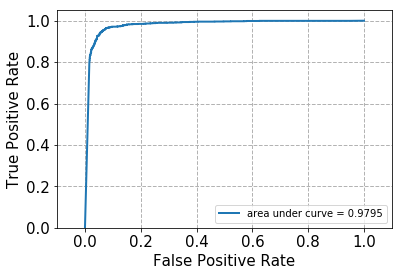

In [65]:
# naive bayes
fit_predict_and_plot_roc(pipe_min_df_3_NMF_NB, train_dataset.data, train_dataset.target <= 3, test_dataset.data, test_dataset.target <= 3)

confusion_matrix = 
 [[1517   73]
 [ 222 1338]]
accuracy score = 0.906349206349
recall score = 0.857692307692
precision score = 0.948263642807
F1 score = 0.900706832716


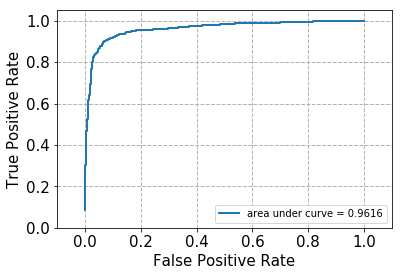

In [66]:
# naive bayes
fit_predict_and_plot_roc(pipe_min_df_3_LSI_NB, train_dataset.data, train_dataset.target <= 3, test_dataset.data, test_dataset.target <= 3)

### (4) Grid search

In [33]:
from sklearn.model_selection import GridSearchCV

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

from sklearn.model_selection import KFold
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', SVC()),
],
memory=memory
)

C_OPTIONS = [0.0001, 1000]
cv = KFold(n_splits=5)

param_grid = [
    {
#         'reduce_dim': [TruncatedSVD(), NMF()],
#         'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'clf': [SVC()],
        'clf__C': C_OPTIONS
    },
#     {
#         'reduce_dim': [TruncatedSVD(), NMF()],
#         'reduce_dim__n_components': N_FEATURES_OPTIONS,
#         'clf': [GaussianNB()],
# #         'clf__C': C_OPTIONS
#     },
]
# reducer_labels = ['LinearSVC', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipeline, cv=cv, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_dataset.data, train_dataset.target < 3)
rmtree(cachedir)
print("The best parameters are %s with a score of %0.2f" %(grid.best_params_, grid.best_score_))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc at 0x121d8eae8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=3, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None), 
None, [ 'From: der10@cus.cam.ac.uk (David Rourke)\n'
  'Subject: xs1100 timing\n'
  'Organization: U of Cambridge, England\n'
  'Lines: 4\n'
  'Nntp-Posting-Host: bootes.cus.cam.ac.uk\n'
  '\n'
  'Could some kind soul tell me the advance timing/revs for a 1981 xs1100 '
  'special\n'
  '(bought in Canada).\n'
  '\n'
  'thanks.\n',
  'From: boyle@cactus.org (Craig Boyle)\n'
  "Subject: Re: New break pads & exhausts after 96K km

_______________________________________________fit_transform_one - 85.1s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), None, <3786x14180 sparse matrix of type '<class 'numpy.int64'>'
	with 287117 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False], dtype=bool))
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=0, tol=0.0), 
None, <3786x14180 sparse matrix of type '<class 'numpy.float64'>'
	with 287117 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False], dtype=bool))
__________

______________________________________________fit_transform_one - 103.7s, 1.7min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), None, <4732x16285 sparse matrix of type '<class 'numpy.int64'>'
	with 363765 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False], dtype=bool))
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=0, tol=0.0), 
None, <4732x16285 sparse matrix of type '<class 'numpy.float64'>'
	with 363765 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False], dtype=bool))
__________

## Full Grid Search (Question 7)

In [43]:
# With header and footer
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', SVC()),
],
memory=memory
)
cv = KFold(n_splits=5)

param_grid = [
    {
        'vect__min_df': [3, 5],
        'vect__analyzer': [stem_rmv_punc, 'word'],
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': [50],
        'clf': [SVC(kernel='linear', probability=True, C=1000)], 
    },
    {
        'vect__min_df': [3, 5],
        'vect__analyzer': [stem_rmv_punc, 'word'],
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': [50],
        'clf': [GaussianNB()],
    },
    {
        'vect__min_df': [3, 5],
        'vect__analyzer': [stem_rmv_punc, 'word'],
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': [50],
        'clf': [LogisticRegression(C=100)], 
        'clf__penalty': ['l1', 'l2']
    }
]

grid = GridSearchCV(pipeline, cv=cv, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_dataset.data, train_dataset.target <= 3)
rmtree(cachedir)
print("The best parameters are %s with a score of %0.2f" %(grid.best_params_, grid.best_score_))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc at 0x121d8eae8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=3, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None), 
None, [ 'From: der10@cus.cam.ac.uk (David Rourke)\n'
  'Subject: xs1100 timing\n'
  'Organization: U of Cambridge, England\n'
  'Lines: 4\n'
  'Nntp-Posting-Host: bootes.cus.cam.ac.uk\n'
  '\n'
  'Could some kind soul tell me the advance timing/revs for a 1981 xs1100 '
  'special\n'
  '(bought in Canada).\n'
  '\n'
  'thanks.\n',
  'From: boyle@cactus.org (Craig Boyle)\n'
  "Subject: Re: New break pads & exhausts after 96K km

KeyboardInterrupt: 

In [56]:
## Without header and footer

# fetch data
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']
train_removedHF = fetch_20newsgroups(subset = 'train', categories = categories, shuffle=True,random_state=None,remove=['headers', 'footers'])
test_removedHF = fetch_20newsgroups(subset = 'test', categories = categories, shuffle=True,random_state=None, remove=['headers', 'footers'])

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', SVC()),
],
memory=memory
)
cv = KFold(n_splits=5)

param_grid = [
    {
        'vect__min_df': [3, 5],
        'vect__analyzer': [stem_rmv_punc, None],
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': [50],
        'clf': [SVC(kernel='linear', probability=True, C=1000)], 
    },
    {
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': [50],
        'clf': [GaussianNB()],
    },
    {
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': [50],
        'clf': [LogisticRegression(C=100)], 
        'clf__penalty': ['l1', 'l2']
    }
]

grid = GridSearchCV(pipeline, cv=cv, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_removedHF.data, train_removedHF.target <= 3)
rmtree(cachedir)
print("The best parameters are %s with a score of %0.2f" %(grid.best_params_, grid.best_score_))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc at 0x121d8eae8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=3, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None), 
None, [ 'ecktons@ucs.byu.edu (Sean Eckton) writes:\n'
  '\n'
  '>I have a Microsoft Serial Mouse and am using mouse.com 8.00 (was using '
  '8.20 \n'
  '>I think, but switched to 8.00 to see if it was any better).  Vertical '
  'motion \n'
  ">is nice and smooth, but horizontal motion is so bad I sometimes can't "
  'click \n'
  '>on something because my mouse jumps around.  I can be moving the mouse '
  'to \n'
  '>the right

KeyboardInterrupt: 